In [1]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler
#
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
%matplotlib inline

In [2]:
 def calculate_snsp(Y, Y_pred):
    tp = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 1)])
    fn = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 0)])
    tn = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 0)])
    fp = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 1)])
    ####
    print("tp:%d\tfn:%d\ttn:%d\tfp:%d" % (tp, fn, tn, fp))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp+tn)/(tp+fn+tn+fp)
    print("Sn: %.2f" % sensitivity)
    print("Sp: %.2f" % specificity)
    print("Accuracy: %.2f" % accuracy)

In [3]:
def load_defined_set():
    train = "/home/galaxy/project/logistic_regression/new/Training_set.txt"
    test = "/home/galaxy/project/logistic_regression/new/Test_set.txt"
    
    def read_file(in_file):
        df = pd.read_table(in_file, sep="\t")
        return df.iloc[:, :-1], df['Label'].tolist()
    
    X_train, Y_train = read_file(train)
    X_test, Y_test = read_file(test)
    return X_train, X_test, Y_train, Y_test

In [4]:
def calculate_ci(Y_train, y_score):
    alpha = .95
    auc, auc_cov = delong_roc_variance(Y_train, y_score)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    ci[ci > 1] = 1
    # print('AUC:', auc)
    # print('AUC COV:', auc_cov)
    # print('95% AUC CI:', ci)
    return ci

In [5]:
import numpy as np
import scipy.stats
from scipy import stats

def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    # order = (-ground_truth).argsort()
    order = np.negative(ground_truth).argsort()
    # label_1_count = int(ground_truth.sum())
    label_1_count = int(sum(ground_truth))
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]
    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [7]:
def plot_roc(feature_num, feature_names, X_data, Y_data, result_file):
    color_db = ['blue','orange','green','grey','purple','olive','sienna','pink','cyan','magenta','yellow']
    height_db = [0.04,0.09,0.14,0.19,0.24,0.29,0.34,0.39,0.45,0.49,0.54]
    f,ax = plt.subplots(figsize=(8,6))
    color_list = color_db[:feature_num] + ['red']
    height_list = height_db[:(feature_num+1)]
    legend_list = feature_names + ["Combine"]
    set_list = [X_data[x] for x in feature_names] + [X_data]
    for i in range(len(set_list)):
        if i != feature_num:
            i_set = [[x] for x in set_list[i]]
        else:
            i_set = set_list[i]
        sc = StandardScaler()
        i_set = sc.fit_transform(i_set)
        ##
        svclassifier = SVC(kernel='rbf', C=100, gamma=0.01, probability=True) ###
        svclassifier.fit(i_set, Y_data)
        if i == feature_num:
             ## calculate Sn and Sp
            Y_pred = svclassifier.predict(i_set)
            calculate_snsp(Y_data, Y_pred)
            ##
        y_score = svclassifier.predict_proba(i_set)[:,1]
        fpr,tpr,threshold = metrics.roc_curve(Y_data, y_score)
        roc_auc = metrics.auc(fpr,tpr)
        ##
        plt.stackplot(fpr, tpr, color='white', alpha = 0.5, edgecolor = 'black')
        plt.plot(fpr, tpr, color=color_list[i], lw = 1.5, label=legend_list[i])
        plt.plot([0,1],[0,1], color = 'black', linestyle = '--', lw = 1)
        plt.xticks(np.arange(0.0, 1.1, step=0.1))
        plt.xlabel("Flase Positive Rate", fontsize=12)
        plt.yticks(np.arange(0.0, 1.1, step=0.1))
        plt.ylabel("True Positive Rate", fontsize=12)
        ci = calculate_ci(Y_data, y_score)
        plt.text(0.7,height_list[i],'%0.2f      %0.2f-%0.2f' % (roc_auc, ci[0], ci[1]), fontsize=10)
        plt.legend(loc='lower center', fontsize=10, frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower center', fontsize=10, frameon=False)
    plt.text(0.7,(height_list[-1]+0.05),'AUC         95%CI', fontsize=10)
    plt.show()
    f.savefig(result_file, bbox_inches='tight')

Training set
tp:18	fn:13	tn:49	fp:11
Sn: 0.58
Sp: 0.82
Accuracy: 0.74


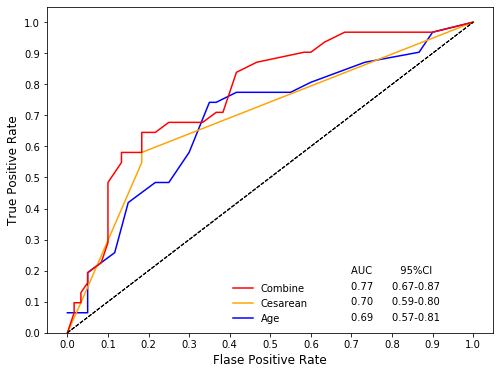

Test set
tp:4	fn:9	tn:24	fp:2
Sn: 0.31
Sp: 0.92
Accuracy: 0.72


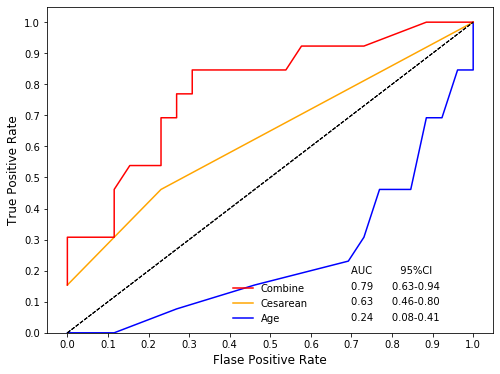

In [8]:
def clinical_model():
    X_train, X_test, Y_train, Y_test = load_defined_set()
    selected_clin = ["Age", "Cesarean"] # , "abortion"
    X_train_clin, X_test_clin = X_train[selected_clin], X_test[selected_clin]

    result_dir = "/home/galaxy/project/logistic_regression/new/"
    feature_num = len(selected_clin)
    feature_names = list(X_train_clin.columns)
    print("Training set")
    plot_roc(feature_num, feature_names, X_train_clin, Y_train, os.path.join(result_dir, "ROC_clinical_train.pdf"))
    print("Test set")
    plot_roc(feature_num, feature_names, X_test_clin, Y_test, os.path.join(result_dir, "ROC_clinical_test.pdf"))
    
clinical_model()